In [1]:
import os
import datetime

import pandas as pd

from astropy.timeseries import TimeSeries
import astropy.units as u

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

OBJ_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data"
CULLED_OBSV_DATA_FILE = os.path.join(OBJ_DATA_DIR, "culledObjDataLID2.csv")
# CULLED_OBSV_DATA_FILE = os.path.join(OBJ_DATA_DIR, "culledObjData.csv.corrLid2.bak")
CULLED_OBSV_DATA_FILE

'/home/ramon/uanl/Tesis/Backup Data/culledObjDataLID2.csv'

In [2]:
allObjDf = pd.read_csv(CULLED_OBSV_DATA_FILE, index_col=0)
del allObjDf['NORM_FLUX']
allObjDf

,MAG,MERR,FLUX,FERR,OTIME,obsv_date,julianDate,RAPERT
0,17.981,0.031,112240.928422,1092.332444,2022-10-21 22:54:21.841000-05:00,2022-10-21,2.459875e+06,20.0
1,18.061,0.027,105232.830111,880.897129,2022-10-21 22:55:22.219000-05:00,2022-10-21,2.459875e+06,20.0
2,18.024,0.030,107386.886365,1014.654385,2022-10-21 22:56:22.714000-05:00,2022-10-21,2.459875e+06,20.0
3,17.929,0.021,116882.973197,781.512461,2022-10-21 22:57:23.081000-05:00,2022-10-21,2.459875e+06,20.0
4,18.002,0.020,109585.034926,707.301735,2022-10-21 22:58:23.606000-05:00,2022-10-21,2.459875e+06,20.0
...,...,...,...,...,...,...,...,...
120,18.291,0.013,107485.838904,366.915207,2022-12-10 20:52:39.875000-06:00,2022-12-10,2.459925e+06,9.0
121,18.288,0.017,101894.619148,451.144250,2022-12-10 20:53:40.007000-06:00,2022-12-10,2.459925e+06,9.0
122,18.329,0.021,95181.216329,547.231803,2022-12-10 20:54:40.156000-06:00,2022-12-10,2.459925e+06,9.0
123,18.361,0.016,99575.214446,399.804131,2022-12-10 20:55:40.318000-06:00,2022-12-10,2.459925e+06,9.0


In [3]:
allObjDf['OTIME'] = pd.to_datetime(allObjDf['OTIME'], utc=True)
allObjDf['OTIME']

0     2022-10-22 03:54:21.841000+00:00
1     2022-10-22 03:55:22.219000+00:00
2     2022-10-22 03:56:22.714000+00:00
3     2022-10-22 03:57:23.081000+00:00
4     2022-10-22 03:58:23.606000+00:00
                    ...               
120   2022-12-11 02:52:39.875000+00:00
121   2022-12-11 02:53:40.007000+00:00
122   2022-12-11 02:54:40.156000+00:00
123   2022-12-11 02:55:40.318000+00:00
124   2022-12-11 02:56:40.463000+00:00
Name: OTIME, Length: 1196, dtype: datetime64[ns, UTC]

In [4]:
observationsTs = TimeSeries(time=allObjDf['OTIME'], 
            data={'mag': allObjDf['MAG']*u.mag, 'err': allObjDf['MERR']*u.mag, 
                  'raw_flux': allObjDf['FLUX']*u.ct, 'ferr': allObjDf['FERR'], 
                  'obsv_date': allObjDf['obsv_date'], 
                  'julianDate': allObjDf['julianDate']})

In [5]:
# light travel time correction

from astropy.coordinates import EarthLocation, SkyCoord

atoCoord = SkyCoord.from_name("ATO J339.9469+45.1464")
iturbideLocation = EarthLocation(lon=-99.895328*u.deg, lat=24.75521 * u.deg, height=2400*u.m)
helioCorrection = observationsTs.time.light_travel_time(atoCoord, kind='heliocentric', location=iturbideLocation)
observationsTs['hjd'] = observationsTs.time + helioCorrection
observationsTs

time,mag,err,raw_flux,ferr,obsv_date,julianDate,hjd
Time,float64,float64,float64,float64,object,float64,Time
2022-10-22 03:54:21.841000,17.981,0.031,112240.92842194808,1092.3324438632785,2022-10-21,2459874.663553512,2022-10-22 03:59:25.480471
2022-10-22 03:55:22.219000,18.061,0.027,105232.83011050562,880.8971288902421,2022-10-21,2459874.664252331,2022-10-22 04:00:25.856822
2022-10-22 03:56:22.714000,18.024,0.03,107386.88636453748,1014.6543851649874,2022-10-21,2459874.6649525044,2022-10-22 04:01:26.350168
2022-10-22 03:57:23.081000,17.929,0.021,116882.9731974464,781.5124606011574,2022-10-21,2459874.6656511966,2022-10-22 04:02:26.715518
2022-10-22 03:58:23.606000,18.002,0.02,109585.0349264616,707.3017352352562,2022-10-21,2459874.6663517174,2022-10-22 04:03:27.238863
2022-10-22 03:59:23.970000,17.988,0.024,111007.22608631152,837.9538608606848,2022-10-21,2459874.667050375,2022-10-22 04:04:27.601213
2022-10-22 04:00:24.671000,18.026,0.02,106108.76269690807,688.9434511375254,2022-10-21,2459874.6677529328,2022-10-22 04:05:28.300553
2022-10-22 04:01:25.043000,18.049,0.022,104076.15767275717,733.3202872846815,2022-10-21,2459874.6684516827,2022-10-22 04:06:28.670901
2022-10-22 04:02:25.528000,18.006,0.021,109081.537426456,732.7290009403191,2022-10-21,2459874.6691517406,2022-10-22 04:07:29.154246


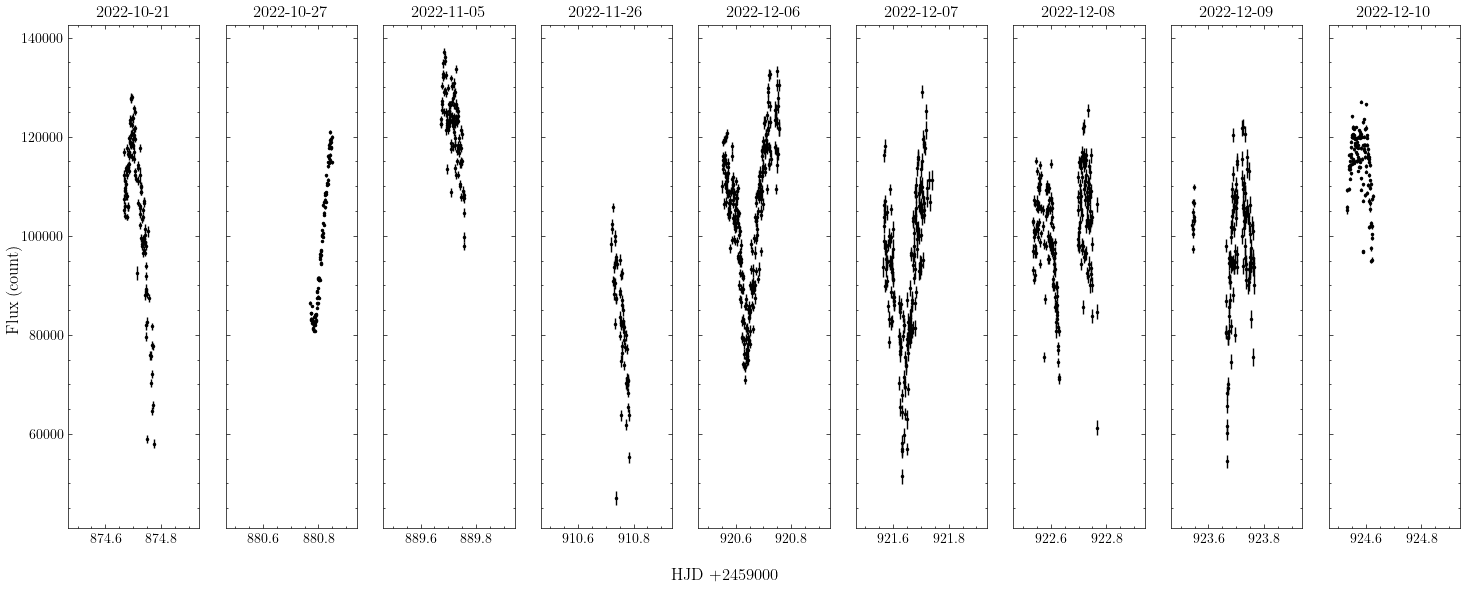

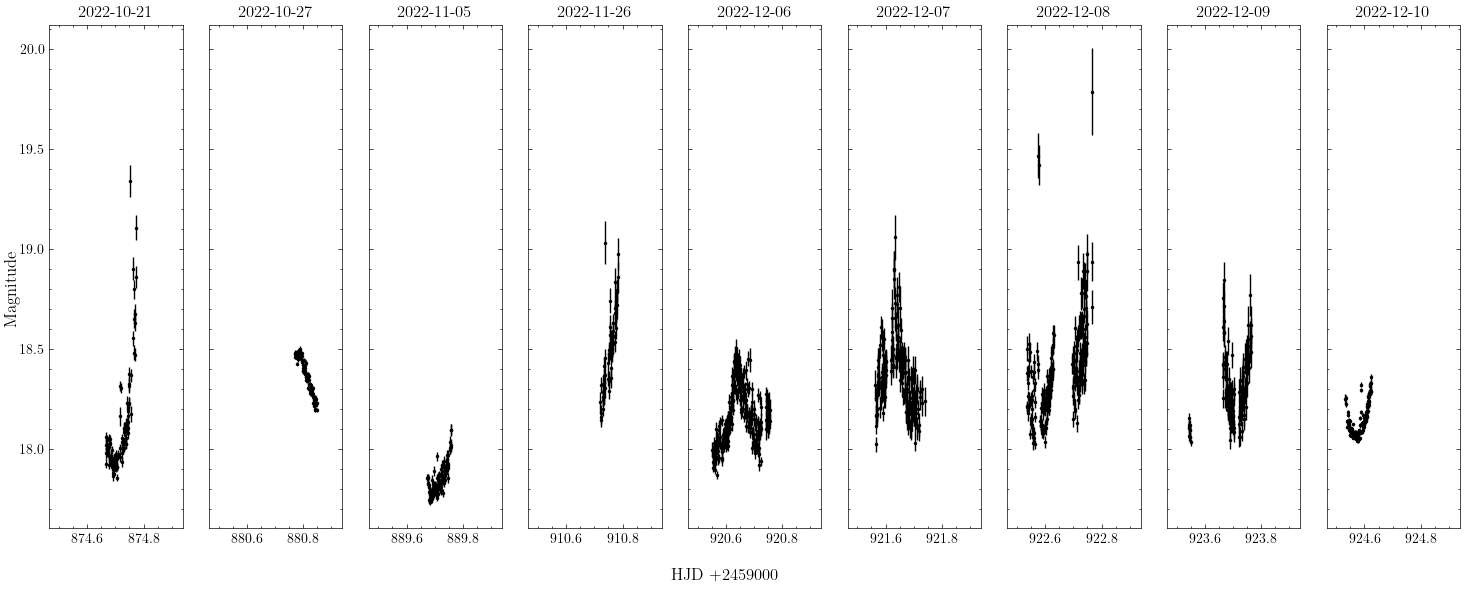

In [37]:
# normalized flux synced in time

# %matplotlib widget

import astropy.units as u
import numpy as np
from astropy.timeseries import TimeSeries
from astropy.time import Time

from dateutil.parser import parse

JD_OFFSET = 2459000

tsObsvDates = allObjDf['obsv_date'].unique()
fig, axs = plt.subplots(nrows=1, ncols=len(tsObsvDates), sharey=True, figsize=(15, 6))
magFig, magAxs = plt.subplots(nrows=1, ncols=len(tsObsvDates), sharey=True, figsize=(15, 6))

for d, ax, magAx in zip(tsObsvDates, axs, magAxs):
    dateTs = observationsTs[observationsTs['obsv_date'] == d]
    ax.errorbar(observationsTs['hjd'].jd - JD_OFFSET, observationsTs['raw_flux'], observationsTs['ferr'], fmt='k.', markersize=3)
    magAx.errorbar(observationsTs['hjd'].jd - JD_OFFSET, observationsTs['mag'], observationsTs['err'], fmt='k.', markersize=3)
    baseMinDayTime = Time(parse(f"{dateTs['obsv_date'][0]}T18:10:00-05:00"))
    baseMaxDayTime = Time(parse(f"{dateTs['obsv_date'][0]}T05:32:00-05:00")) + 1*u.day

    ax.set_xlim(baseMinDayTime.jd - JD_OFFSET, baseMaxDayTime.jd - JD_OFFSET)
    magAx.set_xlim(baseMinDayTime.jd - JD_OFFSET, baseMaxDayTime.jd - JD_OFFSET)
    
    ax.set_title(d)
    magAx.set_title(d)

fig.supylabel("Flux (count)")
magFig.supylabel("Magnitude")

fig.supxlabel(f"HJD +{JD_OFFSET}")
magFig.supxlabel(f"HJD +{JD_OFFSET}")

fig.tight_layout()
magFig.tight_layout()

2022-10-21 (2.59 h) | 2022-10-22 03:54:21.841000+00:00 | 2022-10-22 06:29:46.042000+00:00
	   | 874.6627527894452 | 874.7706717825495
2022-10-27 (1.8616666666666666 h) | 2022-10-28 06:25:14.286000+00:00 | 2022-10-28 08:16:56.430000+00:00
	   | 880.7675264584832 | 880.8450975692831
2022-11-05 (2.0219444444444443 h) | 2022-11-06 04:06:25.878000+00:00 | 2022-11-06 06:07:45.473000+00:00
	   | 889.6711328472011 | 889.7553874189034
2022-11-26 (1.5502777777777779 h) | 2022-11-27 05:13:51.230000+00:00 | 2022-11-27 06:46:52.526000+00:00
	   | 910.7179540507495 | 910.7825523843057
2022-12-06 (4.900277777777778 h) | 2022-12-07 01:13:29.890000+00:00 | 2022-12-07 06:07:31.212000+00:00
	   | 920.5510403933004 | 920.7552223610692
2022-12-07 (4.201388888888889 h) | 2022-12-08 01:30:47.466000+00:00 | 2022-12-08 05:42:52.480000+00:00
	   | 921.5630493750796 | 921.7381074074656
2022-12-08 (5.570277777777778 h) | 2022-12-09 00:48:45.123000+00:00 | 2022-12-09 06:22:58.331000+00:00
	   | 922.5338555905037 |

Text(0, 0.5, 'Duration [h]')

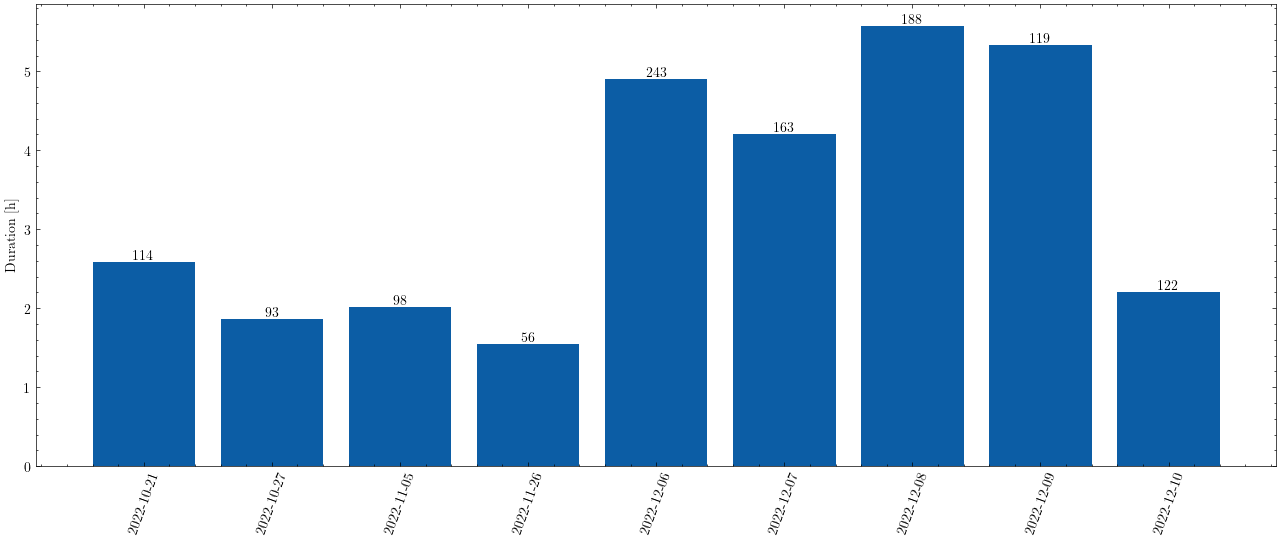

In [30]:
# observation duration bar chart

# %matplotlib widget

import numpy as np

JD_OFFSET = 2459000

tsObsvDates = allObjDf['obsv_date'].unique()
obsvDatesDurations = []
obsvCounts = []
for i, d in enumerate(tsObsvDates):
    obsvData = allObjDf[allObjDf['obsv_date'] == d]
    obsvStart = obsvData['OTIME'].iloc[0]
    obsvEnd = obsvData['OTIME'].iloc[-1]
    durationHours = (obsvEnd - obsvStart).seconds / 3600
    obsvDatesDurations.append(durationHours)
    obsvCounts.append(len(obsvData))
    print(f"{d} ({durationHours} h)", obsvStart, obsvEnd, sep=" | ")
    print("\t  ", obsvStart.to_julian_date() - JD_OFFSET, obsvEnd.to_julian_date() - JD_OFFSET, sep=" | ")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
ax.bar(np.arange(len(tsObsvDates)), obsvDatesDurations)

rects = ax.patches
for rect, label in zip(rects, obsvCounts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")

ax.set_xticks(np.arange(len(tsObsvDates)), tsObsvDates, rotation=70)
ax.set_ylabel("Duration [h]")

# Lomb-Scargle Periodogram

Manually calculating Iturbide period using Astropy Lomb-Scargle periodogram.

**NOT USED ANYMORE**; instead using [ZTF's Time Series tool](https://irsa.ipac.caltech.edu/Missions/ztf.html) on their registered light curve (which yields
a period of $0.333566999 \space \mathrm{d}$).

In [16]:
%%script echo "skipping; using ZTF period instead"
# %matplotlib widget

import astropy.units as u
from astropy.timeseries import LombScargle

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

MIN_FREQ = 0.001
# MAX_FREQ = (1 / (2*(60*u.second).to(u.day))).value # windowing limit windowed observations, taking delta-t = 60sec
MAX_FREQ = 24 # 1 hour period

N_0 = 15
GRID_SIZE = N_0 * (normalizedTs.time.jd[-1] - normalizedTs.time.jd[0]) * float(MAX_FREQ)

# setting a much finer grid for lower frequencies, since this is where we expect the orbital period to be
sub1 = np.linspace(MIN_FREQ, MAX_FREQ, int(GRID_SIZE), endpoint=False)
# sub2 = np.linspace(12, float(MAX_FREQ), int(GRID_SIZE) // 100)
# manualFreqSample = np.concatenate([sub1, sub2])
manualFreqSample = sub1

model = LombScargle.from_timeseries(normalizedTs, signal_column_name='norm_flux')
freqs = manualFreqSample * (1/u.day)

explicitPeriodogram = model.power(freqs)
bestFreq = freqs[np.argmax(explicitPeriodogram)]
bestPeriod = 1.0 / bestFreq
ax.plot(freqs, np.power(explicitPeriodogram, 2))
ax.axvline(bestFreq.value, color='violet', linestyle='--', label=f"Best Frequency = {bestFreq.value:0.3f} day$^{{-1}}$ [P={bestPeriod.to(u.hour):0.3f}]", linewidth=2, alpha=0.7)
# ax.axvline(bestFreq.value*2, color='indigo', linestyle='--', label=f"Best Frequency (2nd harmonic) = {bestFreq.value*2:0.3f} day$^{{-1}} [$P={bestPeriod.to(u.hour)*2:0.3f}$]$", linewidth=2, alpha=0.7)

ax.set_title("Period-Power Spectrum Squared")
ax.set_xlabel("Frequency (day$^{-1}$)")
ax.set_ylabel("Power")

ax.legend()
print(f"Periodo: {bestPeriod.to(u.hour)}")
print(f"Frecuencia: {1.0 / bestPeriod}")

skipping; using ZTF period instead


In [17]:
%%script echo "skipping for LS; need to figure out transits for LS"

index = np.argmax(explicitPeriodogram.power)

period = explicitPeriodogram.period[index]
transitTime = explicitPeriodogram.transit_time[index]
transitDuration = explicitPeriodogram.duration[index]

periodogramStats = model.compute_stats(period, transitDuration, transitTime)
periodogramStats

skipping for LS; need to figure out transits for LS


In [18]:
%%script echo "skipping for LS; need to figure out transits for LS"

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

ax.plot(objTimeSeries.time.jd, objTimeSeries['flux'], 'k.', markersize=3, label="Original")

i = 0
for tt in periodogramStats['transit_times']:
    if periodogramStats['per_transit_count'][i] != 0 or i % 5 == 0:
        lineColor = "blue" if periodogramStats['per_transit_count'][i] != 0 else "orange"
        ax.axvline(tt.jd, linestyle='--', color=lineColor, alpha=0.5)
    i = i + 1

skipping for LS; need to figure out transits for LS


# Phase Plot

/tmp/ipykernel_1100512/461304394.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


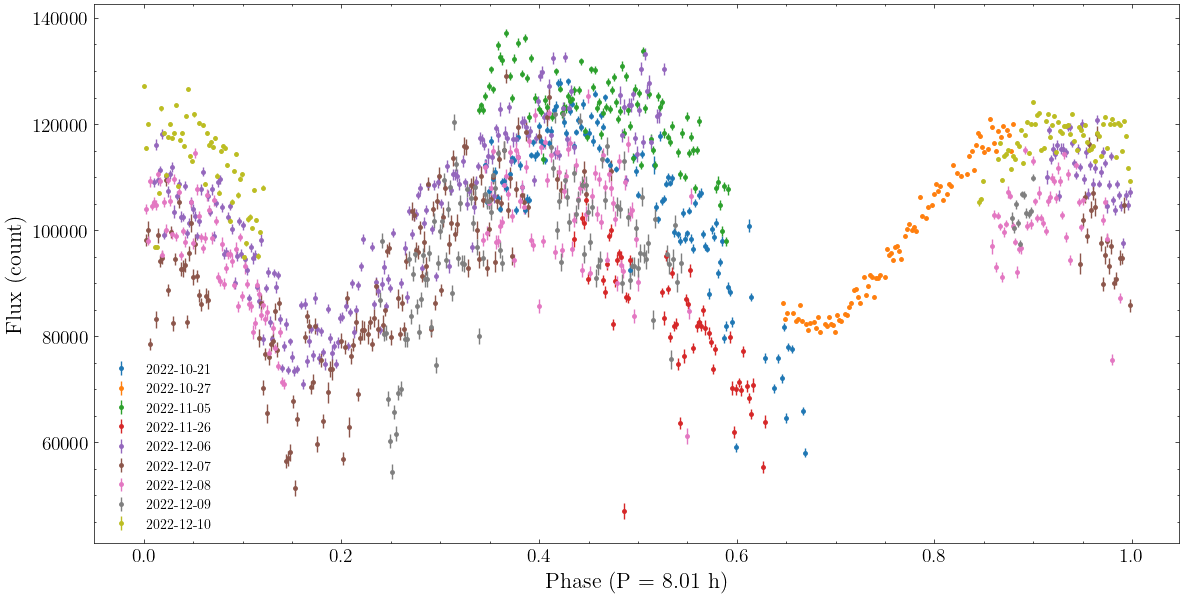

In [18]:
import numpy as np
from matplotlib import cm

bestPeriod = 0.1667834993*u.day # taken from IRSA periodogram
periodHarmonic = 2
period = bestPeriod*periodHarmonic

tsObsvDates = allObjDf['obsv_date'].unique()

cmap = cm.get_cmap('tab10')
dateColors = [cmap(c) for c in np.linspace(0.001, 1, len(tsObsvDates), endpoint=False)]

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
minIndex = np.argmin(observationsTs[observationsTs['obsv_date'] == tsObsvDates[5]]['raw_flux'])
foldedTs = observationsTs.fold(period=period, epoch_time=observationsTs.time[minIndex], normalize_phase=True)
for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = foldedTs[foldedTs['obsv_date'] == obsvDate]
    ax.errorbar(obsvPoints.time.value + 0.5, obsvPoints['raw_flux'], obsvPoints['ferr'], fmt='.', color=color, markersize=5, label=obsvDate)
    # ax.plot(obsvPoints.time.value, obsvPoints['raw_flux'], '.', color=color, markersize=5, label=obsvDate)
ax.legend()

ax.set_xlabel(f"Phase (P = {period.value * 24:.2f} h)", fontsize=16)
ax.set_ylabel("Flux (count)", fontsize=16)

ax.tick_params(labelsize=14)

# Normalized Flux

Calculating normalized flux from phase-folded light curve according to [PHOEBE recommendations](https://github.com/phoebe-project/phoebe2/discussions/507#discussioncomment-1135476). Flux error propagation formula taken from [Astronomy Stack Exchange post](https://astronomy.stackexchange.com/questions/38371/how-can-i-calculate-the-uncertainties-in-magnitude-like-the-cds-does).

In [22]:
import math

def findClosestQuarterPhaseIdx(foldedTs: TimeSeries) -> int:
	adjustedPhases = foldedTs.time.value + 0.5 # so that phases go 0 -> 1
	diff = np.abs(adjustedPhases - 0.25)
	return np.argmin(diff)

quarterPhaseIdx = findClosestQuarterPhaseIdx(foldedTs)
quarterPhaseMag = foldedTs['mag'][quarterPhaseIdx]

foldedTs['norm_flux'] = 10**(-(2/5) * (foldedTs['mag'].value - quarterPhaseMag))
foldedTs['norm_ferr'] = (foldedTs['norm_flux'] * foldedTs['err'] * math.log(10)) / 2.5

observationsTs['norm_flux'] = 10**(-(2/5) * (observationsTs['mag'].value - quarterPhaseMag))
observationsTs['norm_ferr'] = (observationsTs['norm_flux'] * observationsTs['err'] * math.log(10)) / 2.5

/tmp/ipykernel_1100512/2212562510.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


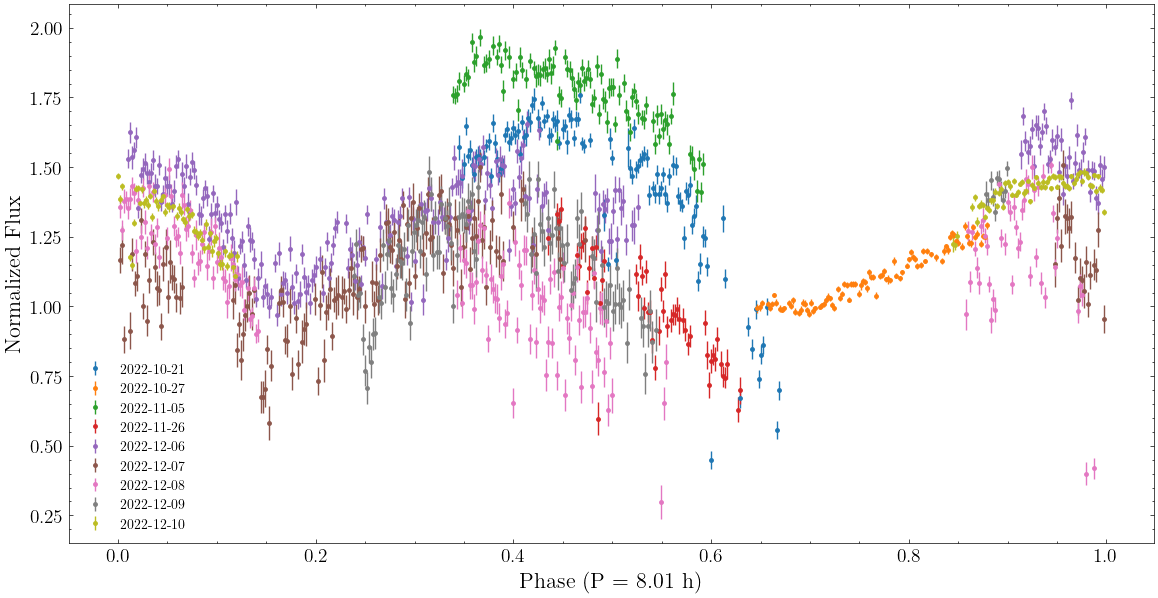

In [23]:
tsObsvDates = allObjDf['obsv_date'].unique()

cmap = cm.get_cmap('tab10')
dateColors = [cmap(c) for c in np.linspace(0.001, 1, len(tsObsvDates), endpoint=False)]

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
minIndex = np.argmin(observationsTs[observationsTs['obsv_date'] == tsObsvDates[5]]['raw_flux'])
for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = foldedTs[foldedTs['obsv_date'] == obsvDate]
    ax.errorbar(obsvPoints.time.value + 0.5, obsvPoints['norm_flux'], obsvPoints['norm_ferr'], fmt='.', color=color, markersize=5, label=obsvDate)
ax.legend()

ax.set_xlabel(f"Phase (P = {period.value * 24:.2f} h)", fontsize=16)
ax.set_ylabel("Normalized Flux", fontsize=16)

ax.tick_params(labelsize=14)

# results look good; export this to import into PHOEBE

In [24]:
observationsTs

time,mag,err,raw_flux,ferr,obsv_date,julianDate,hjd,norm_flux,norm_ferr
Time,float64,float64,float64,float64,object,float64,Time,float64,float64
2022-10-22 03:54:21.841000,17.981,0.031,112240.92842194808,1092.3324438632785,2022-10-21,2459874.663553512,2022-10-22 03:59:25.480471,1.571809828203918,0.04487840090510403
2022-10-22 03:55:22.219000,18.061,0.027,105232.83011050562,880.8971288902421,2022-10-21,2459874.664252331,2022-10-22 04:00:25.856822,1.4601584968117884,0.03631110323220811
2022-10-22 03:56:22.714000,18.024,0.03,107386.88636453748,1014.6543851649874,2022-10-21,2459874.6649525044,2022-10-22 04:01:26.350168,1.5107757319249953,0.041744276150251954
2022-10-22 03:57:23.081000,17.929,0.021,116882.9731974464,781.5124606011574,2022-10-21,2459874.6656511966,2022-10-22 04:02:26.715518,1.6489215731508369,0.03189297076436863
2022-10-22 03:58:23.606000,18.002,0.02,109585.0349264616,707.3017352352562,2022-10-21,2459874.6663517174,2022-10-22 04:03:27.238863,1.5417004529495628,0.028399171846590653
2022-10-22 03:59:23.970000,17.988,0.024,111007.22608631152,837.9538608606848,2022-10-21,2459874.667050375,2022-10-22 04:04:27.601213,1.5617085932653765,0.034521282493954156
2022-10-22 04:00:24.671000,18.026,0.02,106108.76269690807,688.9434511375254,2022-10-21,2459874.6677529328,2022-10-22 04:05:28.300553,1.5079953418017917,0.027778300754698133
2022-10-22 04:01:25.043000,18.049,0.022,104076.15767275717,733.3202872846815,2022-10-21,2459874.6684516827,2022-10-22 04:06:28.670901,1.476386277753865,0.029915644304981746
2022-10-22 04:02:25.528000,18.006,0.021,109081.537426456,732.7290009403191,2022-10-21,2459874.6691517406,2022-10-22 04:07:29.154246,1.5360310683850291,0.029709474819688324


In [25]:
import os

# foldedTs.to_pandas().to_csv(os.path.join(OBJ_DATA_DIR, "Iturbide", "normalized-phase-folded.csv"))
observationsTs.write(os.path.join(OBJ_DATA_DIR, "Iturbide", "normalized-data.ecsv"))